# Object detection of Blood Cells using RetinaNet

Major types of blood cells include red blood cells (erythrocytes), white blood cells (leukocytes), and platelets (thrombocytes). Together, these three kinds of blood cells add up to a total 45% of the blood tissue by volume, with the remaining 55% of the volume composed of plasma, the liquid component of blood.
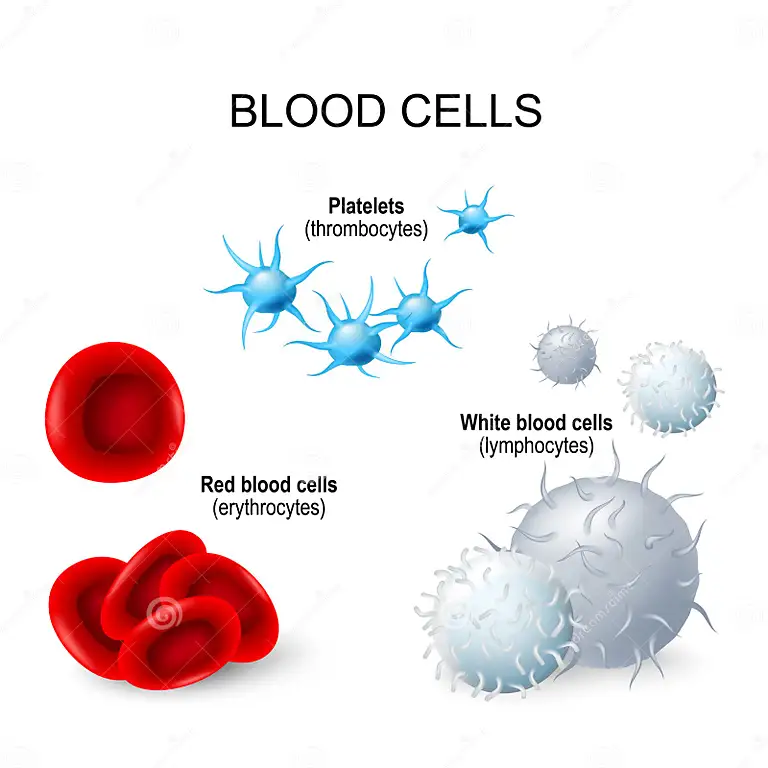

In [1]:
from config import (
    DEVICE, 
    NUM_CLASSES, 
    NUM_EPOCHS, 
    OUT_DIR,
    VISUALIZE_TRANSFORMED_IMAGES, 
    NUM_WORKERS,
    RESIZE_TO,
    VALID_DIR,
    TRAIN_DIR
)
from model import create_model
from custom_utils import (
    Averager, 
    SaveBestModel, 
    save_model, 
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm
from datasets import (
    create_train_dataset, 
    create_valid_dataset, 
    create_train_loader, 
    create_valid_loader
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import torch
import matplotlib.pyplot as plt
import time
import os

C:\Users\mosta\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\mosta\anaconda3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
def train(train_data_loader, model):
    print('Training')
    model.train()
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value
# Function for running validation iterations.
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()
    
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric.reset()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

In [3]:

os.makedirs('outputs', exist_ok=True)
train_dataset = create_train_dataset(TRAIN_DIR)
valid_dataset = create_valid_dataset(VALID_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

# Initialize the model and move to the computation device.
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
scheduler = StepLR(
    optimizer=optimizer, step_size=15, gamma=0.1, verbose=True
)

# To monitor training loss
train_loss_hist = Averager()
# To store training loss and mAP values.
train_loss_list = []
map_50_list = []
map_list = []

# Mame to save the trained model with.
MODEL_NAME = 'model'

# Whether to show transformed images from data loader or not.
if VISUALIZE_TRANSFORMED_IMAGES:
    from custom_utils import show_tranformed_image
    show_tranformed_image(train_loader)

# To save best model.
save_best_model = SaveBestModel()

metric = MeanAveragePrecision()



Number of training samples: 510
Number of validation samples: 146

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps


EPOCH 1 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #1 train loss: 0.862
Epoch #1 mAP: 0.2150513231754303
Took 1.226 minutes for epoch 0

BEST VALIDATION mAP: 0.2150513231754303

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #2 train loss: 0.656
Epoch #2 mAP: 0.38116616010665894
Took 1.487 minutes for epoch 1

BEST VALIDATION mAP: 0.38116616010665894

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #3 train loss: 0.568
Epoch #3 mAP: 0.4808967709541321
Took 1.145 minutes for epoch 2

BEST VALIDATION mAP: 0.4808967709541321

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #4 train loss: 0.526
Epoch #4 mAP: 0.4880797564983368
Took 1.813 minutes for epoch 3

BEST VALIDATION mAP: 0.4880797564983368

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...

EPOCH 5 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #5 train loss: 0.519
Epoch #5 mAP: 0.5082547068595886
Took 1.476 minutes for epoch 4

BEST VALIDATION mAP: 0.5082547068595886

SAVING BEST MODEL FOR EPOCH: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #6 train loss: 0.498
Epoch #6 mAP: 0.5200960636138916
Took 1.153 minutes for epoch 5

BEST VALIDATION mAP: 0.5200960636138916

SAVING BEST MODEL FOR EPOCH: 6

SAVING PLOTS COMPLETE...

EPOCH 7 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #7 train loss: 0.480
Epoch #7 mAP: 0.5132454037666321
Took 1.829 minutes for epoch 6
SAVING PLOTS COMPLETE...

EPOCH 8 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #8 train loss: 0.474
Epoch #8 mAP: 0.5399266481399536
Took 1.494 minutes for epoch 7

BEST VALIDATION mAP: 0.5399266481399536

SAVING BEST MODEL FOR EPOCH: 8

SAVING PLOTS COMPLETE...

EPOCH 9 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #9 train loss: 0.465
Epoch #9 mAP: 0.5464985370635986
Took 1.154 minutes for epoch 8

BEST VALIDATION mAP: 0.5464985370635986

SAVING BEST MODEL FOR EPOCH: 9

SAVING PLOTS COMPLETE...

EPOCH 10 of 10
Training


  0%|          | 0/127 [00:07<?, ?it/s]

Validating


  0%|          | 0/36 [00:00<?, ?it/s]

Epoch #10 train loss: 0.462
Epoch #10 mAP: 0.5571649074554443
Took 1.836 minutes for epoch 9

BEST VALIDATION mAP: 0.5571649074554443

SAVING BEST MODEL FOR EPOCH: 10

SAVING PLOTS COMPLETE...


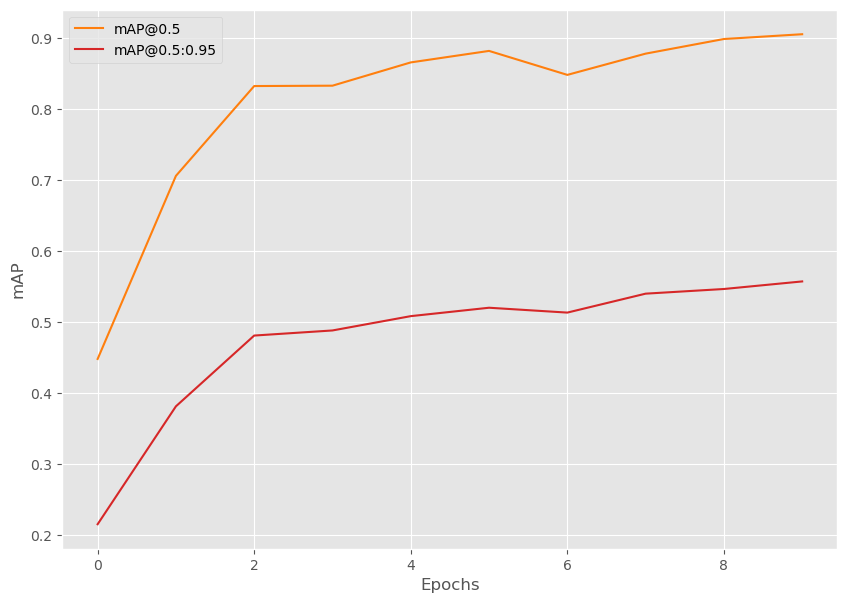

In [4]:
# Training loop.
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True)
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} mAP: {metric_summary['map']}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    # save the best model till now.
    save_best_model(
        model, float(metric_summary['map']), epoch, 'outputs'
    )
    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)
    # scheduler.step()

In [5]:
import torch

from tqdm import tqdm
from config import DEVICE, NUM_CLASSES, NUM_WORKERS
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from model import create_model
from datasets import create_valid_dataset, create_valid_loader

# Evaluation function
def validate(valid_data_loader, model):
    model.eval()
    
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

In [6]:
# Load the best model and trained weights.
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

test_dataset = create_valid_dataset(
    'data/BCCD.v3-raw.voc/test'
)
test_loader = create_valid_loader(test_dataset, num_workers=NUM_WORKERS)

metric_summary = validate(test_loader, model)
print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:04<00:00,  3.81it/s]


mAP_50: 83.992
mAP_50_95: 53.024


In [6]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time

from model import create_model

from config import (
    NUM_CLASSES, DEVICE, CLASSES
)

np.random.seed(42)

# Construct the argument parser.
i="data/BCCD.v3-raw.voc/test"

threshold=0.3


os.makedirs('inference_outputs/images', exist_ok=True)

COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

# Load the best model and trained weights.
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Directory where all the images are present.
DIR_TEST =i
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

for i in range(len(test_images)):
    # Get the image file name for saving output later on.
    image_name = test_images[i].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    print(image.shape)
    # BGR to RGB.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # Make the pixel range between 0 and 1.
    image /= 255.0
    # Bring color channels to front (H, W, C) => (C, H, W).
    image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # Convert to tensor.
    image_input = torch.tensor(image_input, dtype=torch.float).cuda()
    # Add batch dimension.
    image_input = torch.unsqueeze(image_input, 0)
    start_time = time.time()
    # Predictions
    with torch.no_grad():
        outputs = model(image_input.to(DEVICE))
    end_time = time.time()

    # Get the current fps.
    fps = 1 / (end_time - start_time)
    # Total FPS till current frame.
    total_fps += fps
    frame_count += 1

    # Load all detection to CPU for further operations.
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # Carry further only if there are detected boxes.
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # Filter out boxes according to `detection_threshold`.
        boxes = boxes[scores >= threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # Get all the predicited class names.
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # Draw the bounding boxes and write the class name on top of it.
        for j, box in enumerate(draw_boxes):
            class_name = pred_classes[j]
            color = COLORS[CLASSES.index(class_name)]
            # Recale boxes.
            xmin = int((box[0] / image.shape[1]) * orig_image.shape[1])
            ymin = int((box[1] / image.shape[0]) * orig_image.shape[0])
            xmax = int((box[2] / image.shape[1]) * orig_image.shape[1])
            ymax = int((box[3] / image.shape[0]) * orig_image.shape[0])
            cv2.rectangle(orig_image,
                        (xmin, ymin),
                        (xmax, ymax),
                        color[::-1], 
                        3)
            cv2.putText(orig_image, 
                        class_name, 
                        (xmin, ymin-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.8, 
                        color[::-1], 
                        2, 
                        lineType=cv2.LINE_AA)

        cv2.imshow('Prediction', orig_image)
        cv2.waitKey(0)
        cv2.imwrite(f"inference_outputs/images/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

Test instances: 36
(480, 640, 3)
Image 1 done...
--------------------------------------------------
(480, 640, 3)
Image 2 done...
--------------------------------------------------
(480, 640, 3)
Image 3 done...
--------------------------------------------------
(480, 640, 3)
Image 4 done...
--------------------------------------------------
(480, 640, 3)
Image 5 done...
--------------------------------------------------
(480, 640, 3)
Image 6 done...
--------------------------------------------------
(480, 640, 3)
Image 7 done...
--------------------------------------------------
(480, 640, 3)
Image 8 done...
--------------------------------------------------
(480, 640, 3)
Image 9 done...
--------------------------------------------------
(480, 640, 3)
Image 10 done...
--------------------------------------------------
(480, 640, 3)
Image 11 done...
--------------------------------------------------
(480, 640, 3)
Image 12 done...
--------------------------------------------------
(480, 

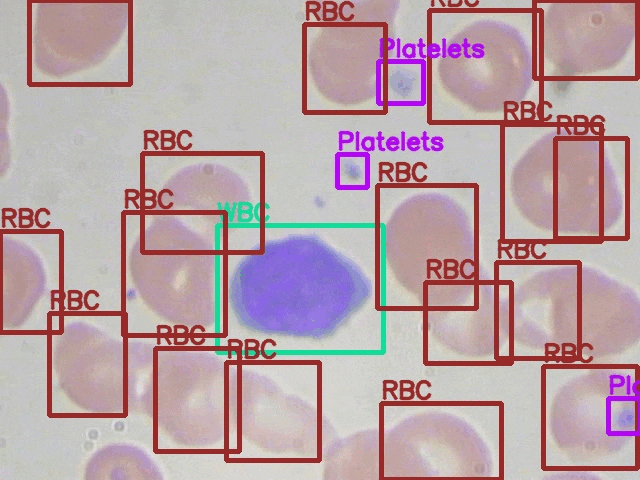